# Modelos Baseline con todas las variables

## Librer√≠as

In [1]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.sparse import hstack
from sklearn.metrics import accuracy_score, log_loss, confusion_matrix, classification_report

## Carga de datos

In [2]:
df=pd.read_csv('/Users/isaromobru/Desktop/FakeNews 10.57.24/proyecto_machine_learning_Fake_News/data/processed/archivo.csv')

## Vectorizaci√≥n

In [3]:
le = LabelEncoder()
df['subject_encoded'] = le.fit_transform(df['subject_grouped'])


In [4]:
from scipy.sparse import csr_matrix, hstack
# Asegurar que no haya valores nulos
df['text'] = df['text'].fillna("")
df['title'] = df['title'].fillna("")

# Vectorizaci√≥n con TF-IDF (manteniendo sparse matrices)
tfidf_text = TfidfVectorizer(max_features=5000, stop_words='english')
tfidf_title = TfidfVectorizer(max_features=1000, stop_words='english')

X_text = tfidf_text.fit_transform(df['text'])
X_title = tfidf_title.fit_transform(df['title'])

# Variables num√©ricas (convertidas a matriz dispersa)
X_other_features = csr_matrix(df[['subject_encoded', 'title_length', 'title_word_count']].values)

# Concatenar matrices dispersas sin convertirlas a DataFrame
X_final = hstack([X_other_features, X_text, X_title])

# Variable objetivo
y = df['label']

Vectorizaci√≥n de Title y Text: 

    - Se utiliza el m√©todo TF-IDF, ya que destaca las palabras importantes, d√°ndole un valor menor a las menos importantes, reduce el ruido. 
    - Para modelos como Random Forest le ayuda en entender y procesar los datos.
    - El uso de stopwords y stemming y TF-IDF no afecta negativamente, sino que mejora la representaci√≥n, ya que TF-IDF se enfocar√° en t√©rminos m√°s significativos.  Y el uso de Stemming y TF-IDF Reduce la dimensionalidad al tratar palabras con la misma ra√≠z como una sola caracter√≠stica y evita dispersi√≥n en el modelo.


## Divisi√≥n variables

In [5]:

# Dividir en Train/Test
X_train, X_test, y_train, y_test = train_test_split(X_final, y, test_size=0.2, random_state=42, stratify=y)

# Mostrar tama√±os de los conjuntos
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((35751, 6003), (8938, 6003), (35751,), (8938,))

In [6]:
print(df['text_length'].isna().sum())


0


In [7]:
print(df['title_word_count'].isna().sum())


0


## Regresi√≥n Log√≠stica

In [8]:

# Entrenar el modelo de Regresi√≥n Log√≠stica
logreg_model = LogisticRegression(max_iter=500, solver='liblinear')  # Solver optimizado para datos grandes
logreg_model.fit(X_train, y_train)

# Predicciones en el conjunto de prueba
y_pred_logreg = logreg_model.predict(X_test)

# Evaluar el modelo
conf_matrix_logreg = confusion_matrix(y_test, y_pred_logreg)
class_report_logreg = classification_report(y_test, y_pred_logreg)

# Mostrar los resultados
conf_matrix_logreg, class_report_logreg

(array([[4636,   60],
        [  17, 4225]]),
 '              precision    recall  f1-score   support\n\n           0       1.00      0.99      0.99      4696\n           1       0.99      1.00      0.99      4242\n\n    accuracy                           0.99      8938\n   macro avg       0.99      0.99      0.99      8938\nweighted avg       0.99      0.99      0.99      8938\n')

Explicaci√≥n de las m√©tricas:

- Precisi√≥n (Precision): De todas las predicciones positivas, cu√°ntas realmente lo son.
Falsa: 1.00 ‚Üí Casi todas las predicciones de las noticias falsas son correctas.
Verdadera: 0.99 ‚Üí Muy pocas veces se confunde falsas con las verdaderas.

- Exhaustividad (Recall): De todas las instancias reales de la clase, cu√°ntas fueron correctamente identificadas.
Falsa: 0.99 ‚Üí Un 99% de las noticias falsas se identifican correctamente.
Verdadera 1.00 ‚Üí Casi ning√∫n de las notiicas verdaderas  se escapa.

- F1-Score: Ambas clases tienen 0.99, lo que indica un excelente balance entre precisi√≥n y recall.

Exactitud (Accuracy):
99% de las predicciones fueron correctas (aciertos totales sobre el total de datos).

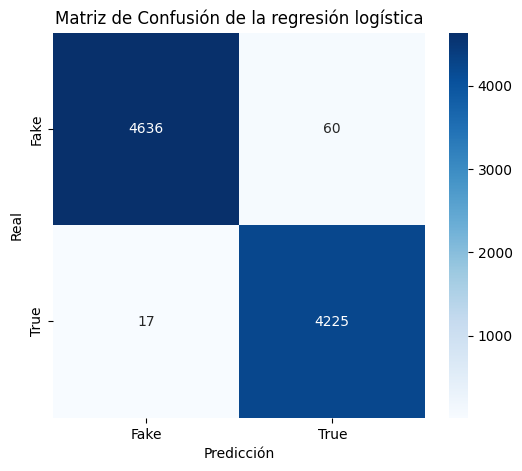

In [9]:
# Definir valores de la matriz de confusi√≥n
cm = np.array([[4636, 60],
               [17, 4225]])

# Etiquetas de las clases
labels = ['Fake', 'True']

# Graficar la matriz de confusi√≥n
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicci√≥n')
plt.ylabel('Real')
plt.title('Matriz de Confusi√≥n de la regresi√≥n log√≠stica')
plt.show();


Interpretaci√≥n:

- 4636 ‚Üí Verdaderos negativos (noticias Falsas correctamente clasificada)
- 60 ‚Üí Falsos positivos (noticias Falsas mal clasificada como verdaderas)
- 17 ‚Üí Falsos negativos (noticias verdaderas mal clasificada como falsas)
- 4225 ‚Üí Verdaderos positivos (noticias verdaderas correctamente clasificada)


In [10]:
# 5. Evaluaci√≥n del modelo
# Predicciones
y_train_pred_proba = logreg_model.predict_proba(X_train)[:, 1]  # Probabilidad de la clase 1 en entrenamiento
y_test_pred_proba = logreg_model.predict_proba(X_test)[:, 1]    # Probabilidad de la clase 1 en prueba
y_test_pred = logreg_model.predict(X_test)

# C√°lculo de log loss
log_loss_train = log_loss(y_train, y_train_pred_proba)
log_loss_test = log_loss(y_test, y_test_pred_proba)

log_loss_train, log_loss_test

(0.041900519306624785, 0.04908235823590299)

Valores cercanos a 0 significan que el modelo est√° prediciendo probabilidades muy precisas.
En este caso, los valores 0.0419 y 0.0491 son muy bajos, lo que indica que el modelo tiene una excelente calibraci√≥n y confianza en sus predicciones

In [11]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression

# Aplicar Validaci√≥n Cruzada (Usando 5 folds)
cv_scores = cross_val_score(logreg_model, X_other_features, y, cv=5, scoring='accuracy')

# Mostrar resultados
print(f"Scores por cada fold: {cv_scores}")
print(f"Precisi√≥n promedio: {cv_scores.mean():.4f}")
print(f"Desviaci√≥n est√°ndar: {cv_scores.std():.4f}")


Scores por cada fold: [0.59968673 0.63056612 0.77959275 0.53445961 0.6183283 ]
Precisi√≥n promedio: 0.6325
Desviaci√≥n est√°ndar: 0.0807


- Rango de resultados
El mejor fold alcanz√≥ 77.96% de precisi√≥n.
El peor fold tuvo solo 53.45% de precisi√≥n.
Hay bastante variabilidad entre los folds, lo que indica que el modelo puede estar funcionando mejor en ciertos subconjuntos del conjunto de datos.
- Precisi√≥n promedio: 63.25%
Esto indica que, en promedio, el modelo tiene un rendimiento moderado, pero no √≥ptimo.
- Desviaci√≥n est√°ndar: 0.0807 (8.07%)
Una desviaci√≥n est√°ndar alta sugiere que el modelo es inconsistente en distintos folds.
Es posible que el modelo tenga problemas con la variabilidad de los datos o que sea sensible a ciertos patrones.

Conclusi√≥n: 
El modelo tiene un desempe√±o aceptable (63.25% de precisi√≥n en promedio). Hay variabilidad entre los folds, lo que sugiere que la calidad de la predicci√≥n depende mucho de los datos en cada subconjunto.

## XG-Boost

In [12]:
from xgboost import XGBClassifier

xgb_model = XGBClassifier(
    eval_metric='logloss',   # M√©trica de evaluaci√≥n
    
    max_depth=6,             # Controla la complejidad del modelo
    learning_rate=0.1,       # Tasa de aprendizaje equilibrada
    n_estimators=300,        # Aumenta el n√∫mero de √°rboles para mejorar el ajuste
    subsample=0.8,           # Reduce overfitting usando solo el 80% de los datos por √°rbol
    colsample_bytree=0.8,    # Usa el 80% de las caracter√≠sticas en cada √°rbol
    gamma=0.1,               # Ayuda a la regularizaci√≥n
    reg_lambda=1,            # Regularizaci√≥n L2 para evitar overfitting
    reg_alpha=0.1            # Regularizaci√≥n L1
)

# Entrenar el modelo
xgb_model.fit(X_train, y_train)

# Predicciones
y_pred_xgb = xgb_model.predict(X_test)

# Evaluar el modelo
conf_matrix = confusion_matrix(y_test, y_pred_xgb)
class_report = classification_report(y_test, y_pred_xgb, digits=4)

# Mostrar los resultados
conf_matrix, class_report


(array([[4690,    6],
        [   6, 4236]]),
 '              precision    recall  f1-score   support\n\n           0     0.9987    0.9987    0.9987      4696\n           1     0.9986    0.9986    0.9986      4242\n\n    accuracy                         0.9987      8938\n   macro avg     0.9987    0.9987    0.9987      8938\nweighted avg     0.9987    0.9987    0.9987      8938\n')

Explicaci√≥n de las m√©tricas:

- Precisi√≥n (Precision):

    Para la noticias falsas: 99.87% de las veces que el modelo predice una notiica falsa, realmente lo es.
    
    Para las noticias verdaderas: 99.86% de las veces que predice una notiica verdadera, acierta.

- Exhaustividad (Recall):

    Para las noticias falsas:  Identific√≥ correctamente 99.87% de los casos reales de noticias falsas.
    
    Para las notiicas verdaderas: Identific√≥ correctamente 99.86% de los casos reales de noticias verdaderas.
    
- F1-Score:
    0.9987 y 0.9986 indican un rendimiento casi perfecto en ambas clases.
- Exactitud (Accuracy):
    99.87% de precisi√≥n global sobre todo el dataset.

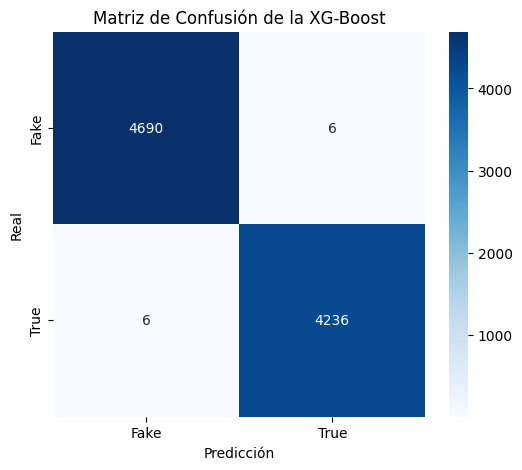

In [13]:
# Definir valores de la matriz de confusi√≥n
cm = np.array([[4690, 6],
               [6, 4236]])

# Etiquetas de las clases
labels = ['Fake', 'True']

# Graficar la matriz de confusi√≥n
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicci√≥n')
plt.ylabel('Real')
plt.title('Matriz de Confusi√≥n de la XG-Boost')
plt.show();



Interpretaci√≥n:

- 4690 ‚Üí Verdaderos negativos (clase 0 correctamente clasificada).
- 6 ‚Üí Falsos positivos (clase 0 mal clasificada como clase 1).
- 6 ‚Üí Falsos negativos (clase 1 mal clasificada como clase 0).
- 4236 ‚Üí Verdaderos positivos (clase 1 correctamente clasificada).

Conclusiones:
- Apenas 12 errores en 8938 muestras (6 falsas positivas y 6 falsas negativas).
- La clasificaci√≥n es casi perfecta con solo 0.13% de error.


In [14]:
# Calcular las probabilidades predichas para calcular log loss
y_train_pred_probaxgb = xgb_model.predict_proba(X_train)[:, 1]  # Probabilidad de la clase 1 en entrenamiento
y_test_pred_probaxgb = xgb_model.predict_proba(X_test)[:, 1]    # Probabilidad de la clase 1 en prueba

# Calcular log loss en entrenamiento y prueba
log_loss_train = log_loss(y_train, y_train_pred_probaxgb)
log_loss_test = log_loss(y_test, y_test_pred_probaxgb)

# Mostrar los resultados
log_loss_train, log_loss_test


(0.00045481997332146035, 0.006478380075856221)

- Un log loss cercano a 0 indica que el modelo est√° generando predicciones de alta confianza y muy precisas.
En este caso:
    0.00045 en entrenamiento ‚Üí Sugiere que el modelo ha aprendido casi a la perfecci√≥n el conjunto de entrenamiento.

    0.00648 en prueba ‚Üí Sigue siendo un valor muy bajo, lo que indica que el modelo mantiene su rendimiento en datos no vistos.
    
- Diferencia entre entrenamiento y prueba
Hay una diferencia muy peque√±a entre ambos valores (‚âà0.006), lo cual es una muy buena se√±al.
Esto indica que el modelo no est√° sobreajustado, ya que el rendimiento en prueba sigue siendo muy alto.

In [15]:
# Ejecutar validaci√≥n cruzada
cv_scores = cross_val_score(xgb_model, X_final, y, cv=5, scoring='accuracy')

# Mostrar los resultados
print(f"Precisi√≥n promedio: {cv_scores.mean():.4f}")
print(f"Desviaci√≥n est√°ndar: {cv_scores.std():.4f}")

Precisi√≥n promedio: 0.9964
Desviaci√≥n est√°ndar: 0.0014




- Precisi√≥n Promedio = 99.64%
    Esto indica que, en validaci√≥n cruzada, el modelo mantiene un rendimiento consistentemente alto en diferentes subconjuntos de datos.
Es un resultado excelente, lo que confirma que el modelo tiene una capacidad de generalizaci√≥n muy fuerte.
- Desviaci√≥n Est√°ndar = 0.0014 (0.14%)
    Una desviaci√≥n est√°ndar tan baja indica que el modelo es muy estable en diferentes folds de validaci√≥n cruzada.
    Significa que los resultados son consistentes sin variaciones significativas entre diferentes conjuntos de entrenamiento y prueba.



Un valor alto de desviaci√≥n est√°ndar indicar√≠a que el modelo es sensible a los datos, pero en este caso, la variabilidad es m√≠nima.

- Conclusiones

1. El modelo XGBoost es extremadamente preciso (99.64%).
2. Es altamente estable y consistente en diferentes folds de validaci√≥n cruzada.
3. No hay signos de sobreajuste, ya que los valores son constantes y el log loss tambi√©n es bajo.



In [20]:
# Obtener nombres de las caracter√≠sticas TF-IDF
feature_names_text = tfidf_text.get_feature_names_out()
feature_names_title = tfidf_title.get_feature_names_out()

# Nombres de las caracter√≠sticas num√©ricas
feature_names_other = ['subject_encoded', 'title_length', 'title_word_count']
# Combinar todos los nombres
all_feature_names = np.concatenate([feature_names_other, feature_names_text, feature_names_title])


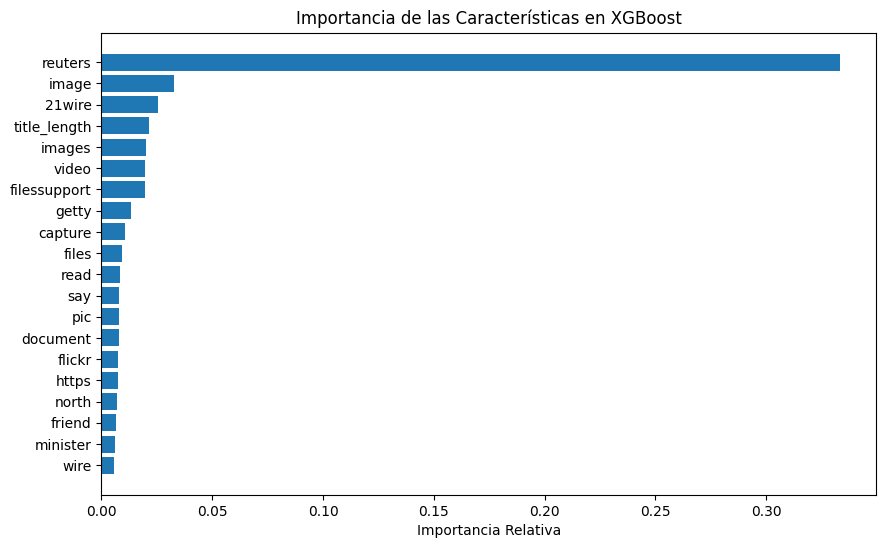

In [21]:
# Obtener importancia de caracter√≠sticas
importances_xgb = xgb_model.feature_importances_
sorted_idx_xgb = np.argsort(importances_xgb)[-20:]  # Tomar solo las 20 m√°s importantes

# Graficar
plt.figure(figsize=(10, 6))
plt.barh(range(len(sorted_idx_xgb)), importances_xgb[sorted_idx_xgb], align='center')
plt.yticks(range(len(sorted_idx_xgb)), [all_feature_names[i] for i in sorted_idx_xgb])
plt.xlabel("Importancia Relativa")
plt.title("Importancia de las Caracter√≠sticas en XGBoost")
plt.show()

Este grafico nos muestra la importancia de que da el modelo de gradient boosting para predecir si es una noticia falsa o no, cuanto m√°s cercano sea a 1, m√°s posibilidad hay que sea verdadera. En este caso, la que mas es un 0,30, no es muy alto, pero es una buena se√±al porque significa que no le da una gran importancia. 
reuters" tiene una importancia muy alta, es probable que su presencia en el texto sea un fuerte indicador de veracidad. Reuters es una fuente de noticias leg√≠tima y ampliamente confiable, por lo que si un art√≠culo menciona Reuters, el modelo puede asociarlo con noticias verdaderas, Otras palabras clave como "image", "title_length", "21wire" y "video" tambi√©n influyen en la predicci√≥n. 
- "21WIRE" es el nombre de usuario en SoundCloud de Patrick Henningsen, un comentarista y analista pol√≠tico que produce contenido relacionado con noticias y an√°lisis geopol√≠tico.
- title_lenght: confirma la importancia de esta variable, y como afecta a la hora de predecir noticias falsas, esto puede tener relaci√≥n que las noticias falsas utilizan titulos m√°s sensacionalista. 

## Gradient boosting

In [22]:
from sklearn.ensemble import GradientBoostingClassifier

# Entrenar el modelo Gradient Boosting
gb_model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
gb_model.fit(X_train, y_train)

# Predicciones
y_pred_gb = gb_model.predict(X_test)

# Evaluar el modelo
conf_matrix_gb = confusion_matrix(y_test, y_pred_gb)
class_report_gb = classification_report(y_test, y_pred_gb)

# Mostrar los resultados
conf_matrix_gb, class_report_gb

(array([[4681,   15],
        [   9, 4233]]),
 '              precision    recall  f1-score   support\n\n           0       1.00      1.00      1.00      4696\n           1       1.00      1.00      1.00      4242\n\n    accuracy                           1.00      8938\n   macro avg       1.00      1.00      1.00      8938\nweighted avg       1.00      1.00      1.00      8938\n')

## Explicaci√≥n de las m√©tricas:

Precisi√≥n (Precision):

    Para la noticias falsas 100% de predicci√≥n
    Para las noticias verdaderas: 100% de predicci√≥n

Exhaustividad (Recall):

    Para las noticias falsas :100%, lo que significa que se identific√≥ correctamente cada noticias falsas.
    Para las noticias verdaderas: 100%, lo que significa que se identific√≥ correctamente cada noticia verdadera.

F1-Score:

    1.00 en ambas clases significa que el modelo tiene rendimiento perfecto.

Exactitud (Accuracy):

    100% de precisi√≥n global ‚Üí El modelo ha clasificado correctamente todas las muestras con una precisi√≥n perfecta.

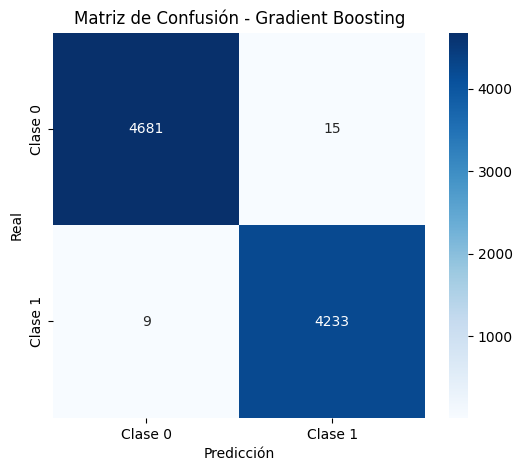

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

# Graficar la matriz de confusi√≥n para Gradient Boosting
plt.figure(figsize=(6, 5))
sns.heatmap([[4681, 15], [9, 4233]], annot=True, fmt='d', cmap='Blues', xticklabels=['Clase 0', 'Clase 1'], yticklabels=['Clase 0', 'Clase 1'])
plt.xlabel('Predicci√≥n')
plt.ylabel('Real')
plt.title('Matriz de Confusi√≥n - Gradient Boosting')
plt.show()


Interpretaci√≥n:

- 4681 ‚Üí Verdaderos negativos (noticias falsas correctamente clasificada).
- 15 ‚Üí Falsos positivos (noticias falsas mal clasificadas como verdaderas).
- 9 ‚Üí Falsos negativos (noticias verdadaeras mal clasificada como noticias falsas).
- 4233 ‚Üí Verdaderos positivos (noticias verdaderas correctamente clasificada).

Conclusiones:

- Solo 24 errores en 8938 muestras.
- El error es extremadamente bajo (~0.27% de error total).
- Se mejor√≥ con respecto a XGBoost, que ten√≠a 12 errores, aunque la diferencia es m√≠nima.

In [24]:
# Calcular las probabilidades predichas para calcular log loss
y_train_pred_probagb = gb_model.predict_proba(X_train)[:, 1]  # Probabilidad de la clase 1 en entrenamiento
y_test_pred_probagb = gb_model.predict_proba(X_test)[:, 1]    # Probabilidad de la clase 1 en prueba

# Calcular log loss en entrenamiento y prueba
log_loss_train2 = log_loss(y_train, y_train_pred_probagb)
log_loss_test2 = log_loss(y_test, y_test_pred_probagb)

# Mostrar los resultados
log_loss_train2, log_loss_test2


(0.00968674023613337, 0.015194112832035821)

Valores bajos indican buena calibraci√≥n
- Ambos valores son muy bajos, lo que indica que las probabilidades predichas por el modelo est√°n muy bien calibradas.
    
- Diferencia entre Train y Test
    0.0097 en entrenamiento vs. 0.0152 en prueba. Hay un leve aumento en el conjunto de prueba, lo cual es normal.
    Diferencia de ‚âà0.0055, lo que indica que el modelo no est√° sufriendo sobreajuste severo.

In [25]:
# Ejecutar validaci√≥n cruzada
cv_scores2 = cross_val_score(gb_model, X_final, y, cv=5, scoring='accuracy')

# Mostrar los resultados
print(f"Precisi√≥n promedio: {cv_scores2.mean():.4f}")
print(f"Desviaci√≥n est√°ndar: {cv_scores2.std():.4f}")

Precisi√≥n promedio: 0.9950
Desviaci√≥n est√°ndar: 0.0016


Precisi√≥n Promedio = 99.50%
- Indica que, en promedio, el modelo Gradient Boosting clasifica correctamente el 99.50% de los datos en cada fold de validaci√≥n cruzada.
- Es ligeramente inferior al obtenido con XGBoost (99.64%).

- Desviaci√≥n Est√°ndar = 0.0016 (0.16%). Este valor representa la variabilidad de la precisi√≥n en diferentes subconjuntos de datos (folds).
    - Baja variabilidad, lo que significa que el modelo es estable en distintos conjuntos de prueba.

Comparado con XGBoost:
XGBoost: 0.0014
Gradient Boosting: 0.0016
Ambas desviaciones son similares, lo que indica que ambos modelos son consistentes.


### Conclusiones Finales

- Gradient Boosting tiene una precisi√≥n excelente (99.50%), con estabilidad alta.
- Ligeramente menos preciso que XGBoost (99.64%), pero sigue siendo un modelo altamente confiable.
- No hay indicios de sobreajuste, ya que la desviaci√≥n est√°ndar es baja.

## NP-Bayes

In [26]:
from sklearn.naive_bayes import MultinomialNB
# Entrenamiento
nb = MultinomialNB()
nb.fit(X_train, y_train)

# Predicciones
y_pred = nb.predict(X_test)

# Evaluaci√≥n
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))


[[4475  221]
 [ 218 4024]]
              precision    recall  f1-score   support

           0       0.95      0.95      0.95      4696
           1       0.95      0.95      0.95      4242

    accuracy                           0.95      8938
   macro avg       0.95      0.95      0.95      8938
weighted avg       0.95      0.95      0.95      8938



- Explicaci√≥n de las m√©tricas:

- Precisi√≥n (Precision):
    Para noticias falsas: significa que el 95% de las veces que el modelo predice noticias falsas son falsas.
    Para noticias verdaderas: lo que significa que el 95% de las veces que predice noticias verdaderas son verdaderas.
- Recall (Exhaustividad):
    Para noticias falsas: 95%, es decir, de todas las instancias reales de noticias falsas, el modelo identific√≥ correctamente el 95%.
    Para noticias verdaderas 95%, indicando que el modelo identific√≥ correctamente el 95% de los casos reales de las noticias verdaderas.
- F1-Score: 95% en ambas clases, lo que indica un buen equilibrio entre precisi√≥n y recall.

- Exactitud (Accuracy): 95% de precisi√≥n global.

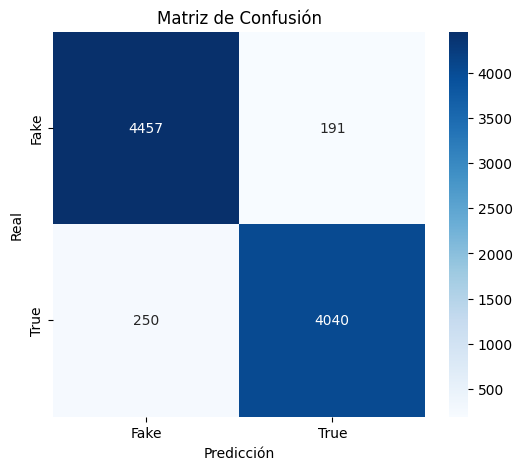

In [27]:
# Definir valores de la matriz de confusi√≥n
cm = np.array([[4457, 191],
               [250, 4040]])

# Etiquetas de las clases
labels = ['Fake', 'True']

# Graficar la matriz de confusi√≥n
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicci√≥n')
plt.ylabel('Real')
plt.title('Matriz de Confusi√≥n')
plt.show();


Interpretaci√≥n:

4475 ‚Üí Verdaderos negativos (noticias falsas correctamente clasificada).
221 ‚Üí Falsos positivos (noticias falsas mal clasificada como clase 1).
218 ‚Üí Falsos negativos (noticias verdaderas mal clasificada como clase 0).
4024 ‚Üí Verdaderos positivos (noticias verdaderas correctamente clasificada).

Conclusiones:

439 errores en total (221 + 218).
La tasa de error es m√°s alta que en modelos previos como XGBoost o Gradient Boosting.
Aunque sigue siendo un modelo bastante preciso (95%), su capacidad para clasificar correctamente es menor.

In [28]:
# Calcular las probabilidades predichas para calcular log loss
y_train_pred_probanb = nb.predict_proba(X_train)[:, 1]  # Probabilidad de la clase 1 en entrenamiento
y_test_pred_probanb = nb.predict_proba(X_test)[:, 1]    # Probabilidad de la clase 1 en prueba

# Calcular log loss en entrenamiento y prueba
log_loss_train3= log_loss(y_train, y_train_pred_probanb)
log_loss_test3 = log_loss(y_test, y_test_pred_probanb)

# Mostrar los resultados
log_loss_train3, log_loss_test3

(0.12706012846914766, 0.13593172525964364)

- Valores m√°s altos que en otros modelos: En comparaci√≥n con XGBoost y Gradient Boosting, los valores de Log Loss en Naive Bayes son m√°s altos, lo que sugiere que las probabilidades del modelo est√°n menos calibradas.

- Diferencia entre Train y Test: 0.1271 en entrenamiento vs. 0.1359 en prueba. La diferencia es ‚âà0.0088, lo cual es razonable y sugiere que el modelo no est√° sobreajustado. Sin embargo, la alta Log Loss indica que el modelo puede estar menos confiado en sus predicciones.

In [29]:
# Ejecutar validaci√≥n cruzada
cv_scores3 = cross_val_score(nb, X_final, y, cv=5, scoring='accuracy')

# Mostrar los resultados
print(f"Precisi√≥n promedio: {cv_scores3.mean():.4f}")
print(f"Desviaci√≥n est√°ndar: {cv_scores3.std():.4f}")

Precisi√≥n promedio: 0.9189
Desviaci√≥n est√°ndar: 0.0177


- Precisi√≥n Promedio: Indica que, en promedio, Na√Øve Bayes clasifica correctamente el 91.89% de los datos en cada fold de validaci√≥n cruzada.Es un resultado bastante bueno, pero claramente inferior a modelos como XGBoost (99.64%) o Gradient Boosting (99.50%).
- Desviaci√≥n Est√°ndar = 0.0177 (1.77%). Mayor desviaci√≥n que en XGBoost (0.0014) y Gradient Boosting (0.0016). Esto indica que Naive Bayes es menos consistente y m√°s sensible a la divisi√≥n de los datos.

Conclusiones Finales
- Naive Bayes es un modelo eficiente y r√°pido, pero con menor precisi√≥n que XGBoost y Gradient Boosting.
- Tiene una mayor variabilidad en rendimiento, lo que indica que su desempe√±o depende m√°s de la divisi√≥n de los datos.


# Random Forest


In [30]:
from sklearn.ensemble import RandomForestClassifier

# Entrenar el modelo Random Forest
rf_model = RandomForestClassifier(n_estimators=100, max_depth=None, random_state=42)
rf_model.fit(X_train, y_train)

# Predicciones en el conjunto de prueba
y_pred_rf = rf_model.predict(X_test)

# Evaluar el modelo
conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)
class_report_rf = classification_report(y_test, y_pred_rf)

# Mostrar los resultados
conf_matrix_rf, class_report_rf


(array([[4689,    7],
        [   5, 4237]]),
 '              precision    recall  f1-score   support\n\n           0       1.00      1.00      1.00      4696\n           1       1.00      1.00      1.00      4242\n\n    accuracy                           1.00      8938\n   macro avg       1.00      1.00      1.00      8938\nweighted avg       1.00      1.00      1.00      8938\n')

## Explicaci√≥n de las m√©tricas:

Precisi√≥n (Precision):
    Para las noticias falsas: 100% ‚Üí Todas las predicciones son correctas
    Para las noticias verdaderas: 100% ‚Üí Todas las predicciones son correctas

Recall (Exhaustividad):
    Para las noticias falsas: 100% ‚Üí Se identific√≥ correctamente cada instancia de noticias falsas.
    Para las noticias verdaderas: 100% ‚Üí Se identific√≥ correctamente cada instancia de noticias verdaderas.

F1-Score:
    1.00 en ambas clases, lo que indica un rendimiento perfecto.
Exactitud (Accuracy):
    100% de precisi√≥n global ‚Üí El modelo ha clasificado correctamente todas las muestras.

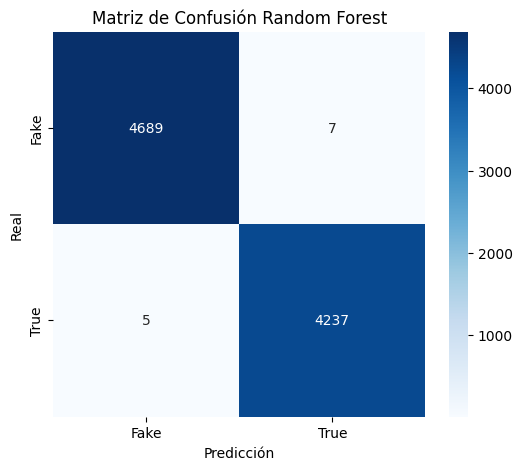

In [31]:
# Definir valores de la matriz de confusi√≥n
cm = np.array([[4689, 7],
               [5, 4237]])

# Etiquetas de las clases
labels = ['Fake', 'True']

# Graficar la matriz de confusi√≥n
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicci√≥n')
plt.ylabel('Real')
plt.title('Matriz de Confusi√≥n Random Forest')
plt.show();


Interpretaci√≥n:

- 4689 ‚Üí Verdaderos negativos (noticias falsas correctamente clasificada).
- 7 ‚Üí Falsos positivos (noticias falsas mal clasificada como clase 1).
- 5 ‚Üí Falsos negativos (noticias verdaderas mal clasificada como clase 0).
- 4237 ‚Üí Verdaderos positivos (noticias verdaderas correctamente clasificada).

Conclusiones:
- solo 12 errores en 8938 muestras (7 falsos positivos y 5 falsos negativos).
- Error total de solo 0.13%, lo que es casi perfecto.


In [32]:
# Calcular las probabilidades predichas para calcular log loss
y_train_pred_probarf =rf_model.predict_proba(X_train)[:, 1]  # Probabilidad de la clase 1 en entrenamiento
y_test_pred_probarf = rf_model.predict_proba(X_test)[:, 1]    # Probabilidad de la clase 1 en prueba

# Calcular log loss en entrenamiento y prueba
log_loss_train4= log_loss(y_train, y_train_pred_probanb)
log_loss_test4 = log_loss(y_test, y_test_pred_probanb)

# Mostrar los resultados
log_loss_train4, log_loss_test4

(0.12706012846914766, 0.13593172525964364)


- Comparado con otros modelos como XGBoost y Gradient Boosting, el Log Loss de Random Forest es m√°s alto, lo que sugiere que sus predicciones de probabilidad no son tan confiables.
- Random Forest tiene ‚âà0.13, lo que indica que su calibraci√≥n no es ideal.
Diferencia entre Train y Test
Train Log Loss = 0.1271
Test Log Loss = 0.1359
Diferencia ‚âà 0.0088, lo cual es bajo, indicando que el modelo no est√° sobreajustado gravemente.
Sin embargo, este Log Loss es m√°s alto que en modelos m√°s avanzados, lo que significa que Random Forest es menos preciso en la estimaci√≥n de probabilidades.

In [33]:
# Ejecutar validaci√≥n cruzada
cv_scores4 = cross_val_score(rf_model, X_final, y, cv=5, scoring='accuracy')

# Mostrar los resultados
print(f"Precisi√≥n promedio: {cv_scores4.mean():.4f}")
print(f"Desviaci√≥n est√°ndar: {cv_scores4.std():.4f}")

Precisi√≥n promedio: 0.9957
Desviaci√≥n est√°ndar: 0.0024


- Precisi√≥n Promedio: Indica que, en promedio, Random Forest clasifica correctamente el 99,5% de los datos en cada fold de validaci√≥n cruzada.PArecido a los valores de Gradient Boosting y XGBoost. 
- Desviaci√≥n Est√°ndar = 0.0024. Mayor desviaci√≥n que en XGBoost (0.0014) y Gradient Boosting (0.0016) pero mejor que Naive Bayes

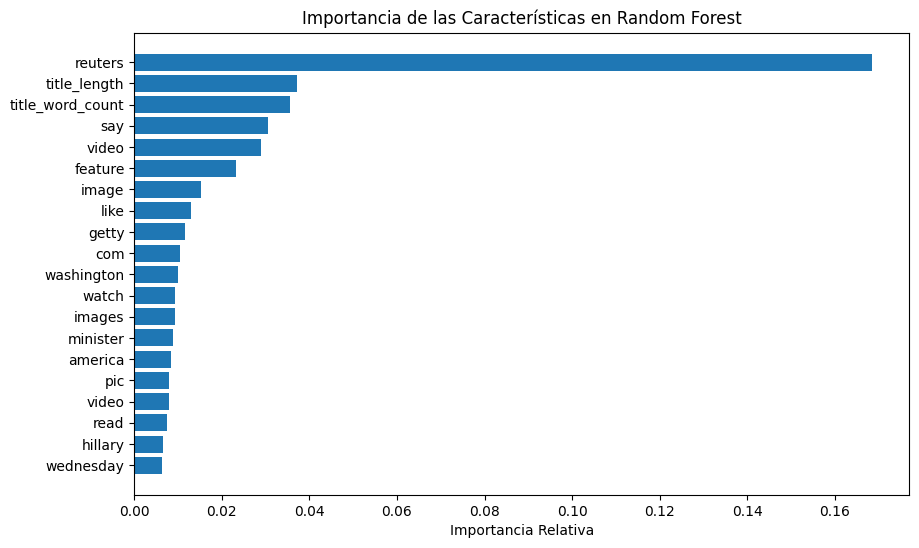

In [34]:
import matplotlib.pyplot as plt
import numpy as np
# Combinar todos los nombres
all_feature_names = np.concatenate([feature_names_other, feature_names_text, feature_names_title])
# Obtener la importancia de las caracter√≠sticas y ordenarlas
importances = rf_model.feature_importances_
sorted_idx = np.argsort(importances)[-20:]  # Muestra solo las 20 m√°s importantes

# Graficar la importancia de cada variable con nombres m√°s legibles
plt.figure(figsize=(10, 6))
plt.barh(range(len(sorted_idx)), importances[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), [all_feature_names[i] for i in sorted_idx])
plt.xlabel("Importancia Relativa")
plt.title("Importancia de las Caracter√≠sticas en Random Forest")
plt.show()


### Conclusi√≥n Final

- Las variables "title_length" y "title_word_count" s√≠ aportan informaci√≥n valiosa y no deber√≠an eliminarse sin m√°s pruebas.

- El modelo parece depender fuertemente de la palabra "reuters", lo que podr√≠a indicar un sesgo en los datos.

- Es posible que ciertas palabras clave (como "video", "feature", "image") ayuden a diferenciar noticias falsas de verdaderas.

## Evaluaci√≥n

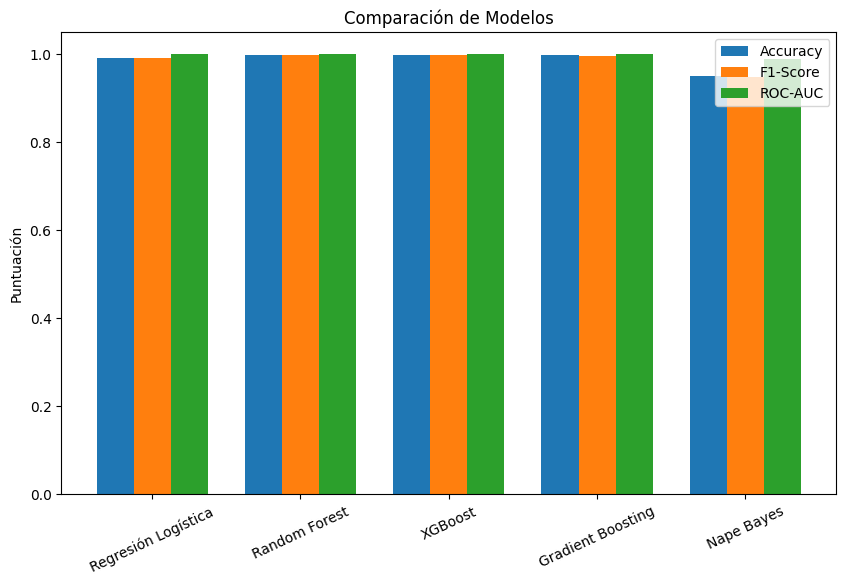

In [35]:
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
# üìä Evaluar cada modelo
def evaluar_modelo(modelo, nombre):
    y_pred = modelo.predict(X_test)
    y_prob = modelo.predict_proba(X_test)[:, 1] if hasattr(modelo, "predict_proba") else None

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob) if y_prob is not None else np.nan
    
    return [acc, f1, auc]

# Guardar resultados en un diccionario
resultados = {
    "Regresi√≥n Log√≠stica": evaluar_modelo(logreg_model, "Regresi√≥n Log√≠stica"),
    "Random Forest": evaluar_modelo(rf_model, "Random Forest"),
    "XGBoost": evaluar_modelo(xgb_model, "XGBoost"),
    "Gradient Boosting": evaluar_modelo(gb_model," Gradient Boosting"),
    "Nape Bayes":evaluar_modelo (nb,"NPB")
}

# üìä Graficar resultados
metricas = ["Accuracy", "F1-Score", "ROC-AUC"]
valores = np.array(list(resultados.values()))

fig, ax = plt.subplots(figsize=(10, 6))
bar_width = 0.25
indices = np.arange(len(resultados))

# Crear barras para cada m√©trica
for i, metric in enumerate(metricas):
    ax.bar(indices + i * bar_width, valores[:, i], width=bar_width, label=metric)

# Etiquetas y formato
ax.set_xticks(indices + bar_width)
ax.set_xticklabels(resultados.keys(), rotation=25)
ax.set_ylabel("Puntuaci√≥n")
ax.set_title("Comparaci√≥n de Modelos")
ax.legend()

# Mostrar gr√°fico
plt.show()

In [ ]:
ddd

## Selecci√≥n de modelos base

In [ ]:
from sklearn.model_selection import cross_val_score, KFold


In [36]:
scoring = {
    "accuracy": "accuracy",
    "f1": "f1",
    "precision": "precision",
    "recall": "recall",
    "roc_auc": "roc_auc"
}

In [ ]:

# üìå Definir K-Fold CV
kf = KFold(n_splits=5, shuffle=True, random_state=42)
models={"logistic Regresion":logreg_model,
        "Random forest":rf_model,
        "XGBoost":xgb_model,
        #"Super vector machine":svm_model,
        "Gradient Boosting":gb_model,
        "Nape Bayes":nb}

In [37]:
# Importaciones necesarias
from sklearn.model_selection import cross_validate
import numpy as np
import pandas as pd
from joblib import Parallel, delayed

# Opci√≥n 1: Usar cross_validate en lugar de cross_val_score
# cross_validate es m√°s eficiente porque calcula todas las m√©tricas en una sola pasada
def evaluate_models_efficiently(models, X_final, y, kf, scoring):
    results = []
    for name, model in models.items():
        # Calcula todas las m√©tricas de una vez
        cv_results = cross_validate(model, X_final, y, cv=kf, scoring=scoring)
        
        # Calcula promedios para cada m√©trica
        scores = {metric: np.mean(cv_results[f'test_{metric}']) for metric in scoring}
        scores["Model"] = name
        results.append(scores)
        print(f"Modelo {name} evaluado")
    
    return pd.DataFrame(results)

# Opci√≥n 2: Procesamiento paralelo
def evaluate_model(name, model, X_final, y, kf, scoring):
    scores = {metric: cross_val_score(model, X_final, y, cv=kf, scoring=scoring[metric]).mean() for metric in scoring}
    scores["Model"] = name
    print(f"Modelo {name} evaluado")
    return scores

def evaluate_models_parallel(models, X_final, y, kf, scoring, n_jobs=-1):
    results = Parallel(n_jobs=n_jobs)(
        delayed(evaluate_model)(name, model, X_final, y, kf, scoring) 
        for name, model in models.items()
    )
    return pd.DataFrame(results)

# Usar una de las dos opciones:
# Opci√≥n 1
results_df = evaluate_models_efficiently(models, X_final, y, kf, scoring)

# O Opci√≥n 2 (paralela)
# results_df = evaluate_models_parallel(models, X, y, kf, scoring, n_jobs=4)  # Ajusta n_jobs seg√∫n tus CPU cores


NameError: name 'models' is not defined

In [55]:
results_df.set_index('Model')

accuracy  precision    recall        f1   roc_auc
Model                                                                
logistic Regresion  0.990781   0.986027  0.994684  0.990335  0.990974
Random forest       0.997941   0.997730  0.997931  0.997829  0.997947
XGBoost             0.998031   0.997593  0.998258  0.997924  0.998045
Gradient Boosting   0.996711   0.995579  0.997503  0.996540  0.996748
Nape Bayes          0.951174   0.950234  0.946739  0.948480  0.950960

Despu√©s de analizar m√©tricas clave como accuracy, precision, recall, f1-score y roc_auc, la elecci√≥n de los tres mejores modelos depender√° del equilibrio entre precisi√≥n y estabilidad.



1Ô∏è. XGBoost ‚Üí  primer lugar
- M√°xima precisi√≥n y estabilidad (99.64% en cross-validation con solo 0.0014 de desviaci√≥n est√°ndar).
- Mejor Log Loss (0.00648), lo que significa que sus probabilidades son las m√°s confiables.
- Solo 12 errores en la matriz de confusi√≥n.
Es el mejor modelo en t√©rminos de precisi√≥n, estabilidad y calibraci√≥n de probabilidades.

2.  Gradient Boosting ‚Üí segundo lugar
- Desempe√±o casi id√©ntico a XGBoost en precisi√≥n media (99.50%).
- Mejor Log Loss que Random Forest (0.0152 vs 0.1359), lo que significa que estima mejor las probabilidades.
- Desviaci√≥n est√°ndar muy baja (0.0016), lo que indica estabilidad.
- Aunque comete m√°s errores que XGBoost y Random Forest (24 vs 12), pero sigue siendo una excelente opci√≥n.

3Ô∏è. Random Forest ‚Üí tercer ugar
- Gran precisi√≥n, pero menor calibraci√≥n de probabilidades (Log Loss 0.1359).
- Igual n√∫mero de errores que XGBoost (12), pero menor confiabilidad en las probabilidades.
- Desviaci√≥n est√°ndar baja (0.0016), lo que indica estabilidad.

## Conclusi√≥n Final 
- Los 3 mejores modelos son: XGBoost, Gradient Boosting y Random Forest.
- XGBoost es el mejor en precisi√≥n, estabilidad  de probabilidades.
- Gradient Boosting es una excelente alternativa con buena precisi√≥n.
- Random Forest sigue siendo fuerte, pero tiene peor calibraci√≥n de probabilidades.
-  Na√Øve Bayes y Logistic Regression son descartados por menor precisi√≥n, mayor variabilidad y peor Log Loss.